## ARIMA model testing
So, we may have jumped the gun a little bit by going right for a full bootstrapped hyperparameter grid search here. The testing loop is working, but we are getting lots of warnings about failed convergence and similar. Also, we have a pretty big parameter space to explore given how slow the model fits. I also feel like I lack the familiarity with ARIMA models to do massive, parallel experiments in intelligent ways. So, for now, the plan is to step back and do some manual experimentation. The rough list of goals is as follows.
1. Build some intuition about ARIMA models, especially in relation to our data.
2. Find some initial conditions that are close to a 'good' solution to constrain the gridsearch somewhat.
3. Do some sanity checking to make a few decisions about how to set the bootstrapping loop up.
4. Convince ourselves that ARIMA models are even worth trying for this dataset in the first place.

The big issue here will be the fact that we have >3000 separate time courses, one for each county. Some might be well behave for ARIMA, while others not so much. We can't inspect each one, so we will have to pick a few at random to work with. 

First up, let's just make some quick diagnostic plots which have come up several times in my reading about ARIMA models.

In [1]:
# Number of counties to include in our testing
num_counties = 100

# Load parsed data - note: 38 is the max block size because we lost
# the first row of each timecourse to differencing
block_size = 37

In [2]:
import sys
sys.path.append('..')
import config as conf

paths = conf.DataFilePaths()
params = conf.ARIMA_model_parameters()

import numpy as np
import pandas as pd
import statsmodels as sm
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import product
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima.model import ARIMA

print(f'Statsmodels: {sm.__version__}')

Statsmodels: 0.13.5


In [3]:
input_file = f'{paths.PARSED_DATA_PATH}/{params.input_file_root_name}{block_size}.npy'
timepoints = np.load(input_file)

print(f'Timepoints shape: {timepoints.shape}')
print()
print('Column types:')
print()

for column in timepoints[0,0,0,0:]:
    print(f'\t{type(column)}')

print()
print(f'Example block:')
print()

for row in timepoints[0,0,0:,:]:
    print('\t', end = '')
    for col in row:
        print(f'{col:.2E}', end=' ')

    print()

Timepoints shape: (1, 3135, 37, 6)

Column types:

	<class 'numpy.float64'>
	<class 'numpy.float64'>
	<class 'numpy.float64'>
	<class 'numpy.float64'>
	<class 'numpy.float64'>
	<class 'numpy.float64'>

Example block:

	1.00E+03 1.57E+18 2.88E+00 1.20E+03 1.00E+00 -1.23E-01 
	1.00E+03 1.57E+18 3.06E+00 1.27E+03 2.00E+00 1.71E-01 
	1.00E+03 1.57E+18 2.99E+00 1.24E+03 3.00E+00 -6.26E-02 
	1.00E+03 1.58E+18 2.99E+00 1.24E+03 4.00E+00 0.00E+00 
	1.00E+03 1.58E+18 2.97E+00 1.24E+03 5.00E+00 -2.41E-02 
	1.00E+03 1.58E+18 2.91E+00 1.22E+03 6.00E+00 -5.98E-02 
	1.00E+03 1.58E+18 2.93E+00 1.23E+03 7.00E+00 2.39E-02 
	1.00E+03 1.59E+18 3.00E+00 1.26E+03 8.00E+00 6.69E-02 
	1.00E+03 1.59E+18 3.00E+00 1.26E+03 9.00E+00 4.78E-03 
	1.00E+03 1.59E+18 3.02E+00 1.26E+03 1.00E+01 1.43E-02 
	1.00E+03 1.59E+18 3.08E+00 1.29E+03 1.10E+01 6.45E-02 
	1.00E+03 1.60E+18 3.17E+00 1.33E+03 1.20E+01 9.08E-02 
	1.00E+03 1.60E+18 3.21E+00 1.34E+03 1.30E+01 3.11E-02 
	1.00E+03 1.60E+18 3.19E+00 1.34E+03 1.40E+01 -1.2

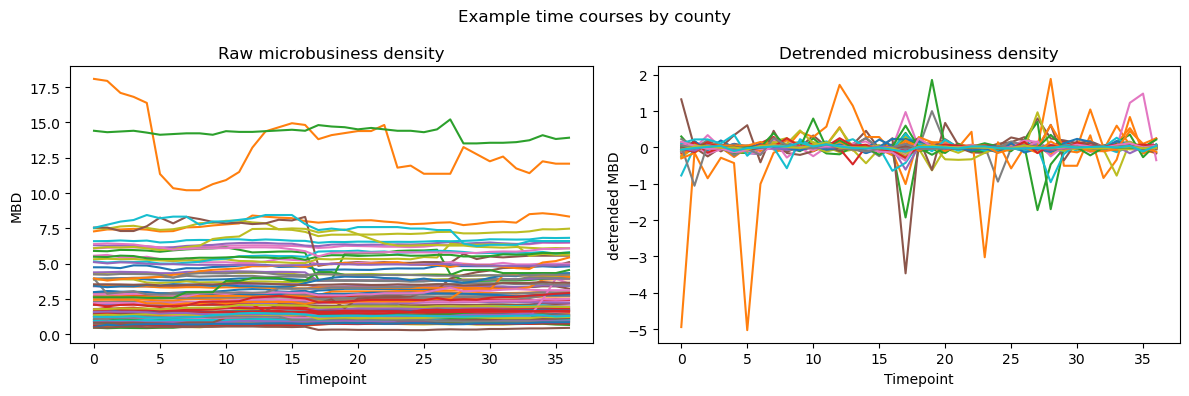

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))

for i in range(num_counties):
        
    ax[0].plot(list(range(len(timepoints[0,1,:,2]))), timepoints[0,i,:,2])
    ax[0].set_title('Raw microbusiness density')
    ax[0].set_xlabel(f'Timepoint')
    ax[0].set_ylabel(f'MBD')

for i in range(num_counties):
        
    ax[1].plot(list(range(len(timepoints[0,1,:,2]))), timepoints[0,i,:,5])
    ax[1].set_title('Detrended microbusiness density')
    ax[1].set_xlabel(f'Timepoint')
    ax[1].set_ylabel(f'detrended MBD')

plt.suptitle('Example time courses by county')
plt.tight_layout()

OK, hard to draw any conclusions from manually inspecting such a small number of counties. 

But, we know from our unit root testing (see notebook #02.2) that we have a lot of non-stationary counties (and some other weird stuff) and this is supported by the plots above. The issues with non-stationarity are mostly alleviated by one differencing, at least according to unit root testing. So, let's use 1 for our model's differencing degree.

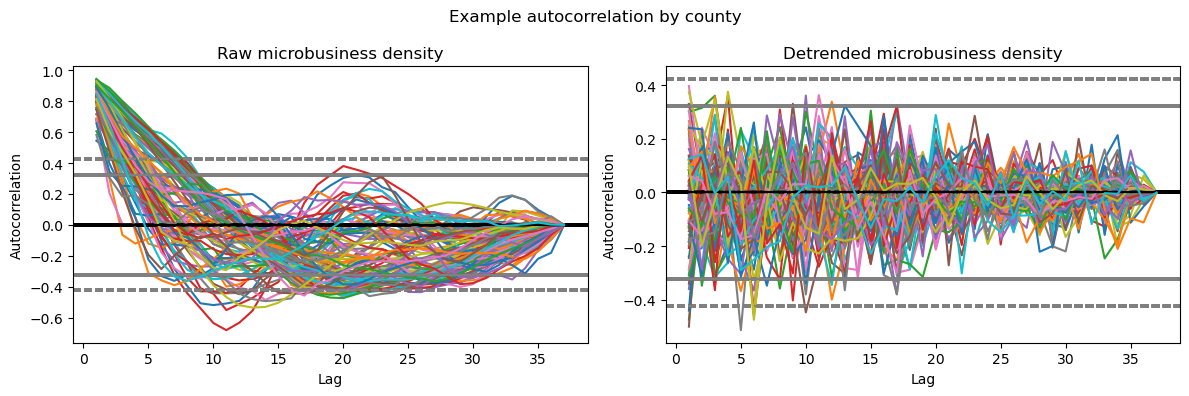

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))

for i in range(num_counties):
        
    autocorrelation_plot(pd.Series(timepoints[0,i,:,2]), ax=ax[0])
    ax[0].set_title('Raw microbusiness density')

for i in range(num_counties):
        
    autocorrelation_plot(pd.Series(timepoints[0,i,:,5]), ax=ax[1])
    ax[1].set_title('Detrended microbusiness density')

plt.suptitle('Example autocorrelation by county')
plt.tight_layout()

From the autocorrelation plots we can see that raw MBD data tends to have good positive autocorrelation out to about 5 lags or so for most of the counties we looked at. After that it tends to dip negative in most cases. Will probably want to start with lag order around 5. After differencing, any consistent autocorrelation signature is pretty much gone. Let's fit an ARIMA model to a few of these counties and see what we get.

In [6]:
fitted_models = {
    'MBD ARIMA(5,0,0)': [],
    'MBD ARIMA(5,1,0)': [],
    'detrended MBD ARIMA(5,0,0)': [],
    'detrended MBD ARIMA(5,1,0)': []
}

for i in range(num_counties):
    model = ARIMA(pd.Series(timepoints[0,i,:,2]), order=(5,0,0))
    model_fit = model.fit()
    fitted_models['MBD ARIMA(5,0,0)'].append(model_fit)

for i in range(num_counties):
    model = ARIMA(pd.Series(timepoints[0,i,:,2]), order=(5,1,0))
    model_fit = model.fit()
    fitted_models['MBD ARIMA(5,1,0)'].append(model_fit)

for i in range(num_counties):
    model = ARIMA(pd.Series(timepoints[0,i,:,5]), order=(5,0,0))
    model_fit = model.fit()
    fitted_models['detrended MBD ARIMA(5,0,0)'].append(model_fit)

for i in range(num_counties):
    model = ARIMA(pd.Series(timepoints[0,i,:,5]), order=(5,1,0))
    model_fit = model.fit()
    fitted_models['detrended MBD ARIMA(5,1,0)'].append(model_fit)

/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameter

In [7]:
plot_rows = [0,1]
plot_cols = [0,1]
plot_dim = 3

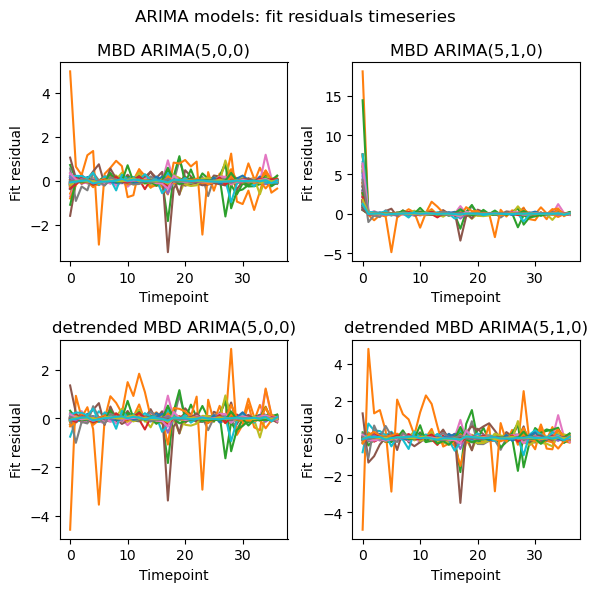

In [8]:
fig, ax = plt.subplots(len(plot_cols), len(plot_rows), figsize=(len(plot_rows) * plot_dim, len(plot_rows) * plot_dim))

for (model_string, fitted_model), subplot in zip(fitted_models.items(), product(plot_rows, plot_cols)):

    for i in range(num_counties):
        residuals = pd.DataFrame(fitted_models[model_string][i].resid)
        residuals.plot(legend=False, ax=ax[subplot])
        ax[subplot].set_xlabel(f'Timepoint')
        ax[subplot].set_ylabel(f'Fit residual')
        ax[subplot].set_title(model_string)

plt.suptitle('ARIMA models: fit residuals timeseries')
plt.tight_layout()

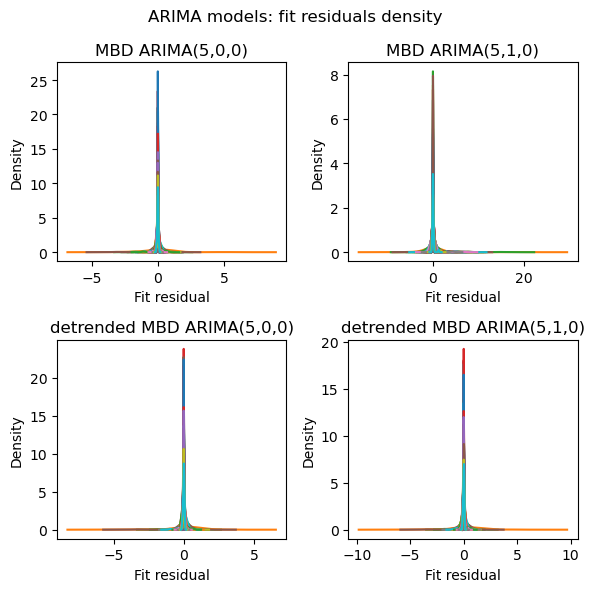

In [9]:
fig, ax = plt.subplots(len(plot_cols), len(plot_rows), figsize=(len(plot_rows) * plot_dim, len(plot_rows) * plot_dim))

for (model_string, fitted_model), subplot in zip(fitted_models.items(), product(plot_rows, plot_cols)):

    for i in range(num_counties):
        residuals = pd.DataFrame(fitted_models[model_string][i].resid)
        residuals.plot(kind='kde', legend=False, ax=ax[subplot])
        ax[subplot].set_xlabel(f'Fit residual')
        ax[subplot].set_ylabel(f'Density')
        ax[subplot].set_title(model_string)

plt.suptitle('ARIMA models: fit residuals density')
plt.tight_layout()

OK, strange - first observation. The fit residuals look mostly normal-ish about zero, but the all have a small bump at high values. Looking at the time series plots, it's apparent that this bump is coming from the first, or maybe the first few timepoints. Not sure why this would be. Chopping off an arbitrary few points from each timeseries and running the fits again gives the same result. The first timepoint in the series always has a high fit residual. In most cases very much higher than the rest of the datapoints.

I think I figured it out. It looks like when the difference degree is set to 1, the residual for the first point is always very high. Not sure why this is, or if there is some parameter I am not setting which is supposed to solve it, but for now, at least we know how to avoid it. Kind of annoying to have to manually difference the data rather than setting it when setting up the model, but OK.

Let's keep experimenting.

In [47]:
fitted_models = {}
moving_average_orders = [0]
difference_degrees = [0]
lag_orders = [0,1,2,3,4,5,6,7]

for model_parameter_set in product(lag_orders, difference_degrees, moving_average_orders):

    print(f'Model: {model_parameter_set}')
    fitted_models[f'ARIMA{model_parameter_set}'] = []

    for i in range(num_counties):
        model = ARIMA(pd.Series(timepoints[0,i,:,5]), order=model_parameter_set)
        model_fit = model.fit()
        fitted_models[f'ARIMA{model_parameter_set}'].append(model_fit)

Model: (0, 0, 0)


/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum 

Model: (1, 0, 0)


/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model: (2, 0, 0)


/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model: (3, 0, 0)


/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Model: (4, 0, 0)


/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals

Model: (5, 0, 0)


/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum 

Model: (6, 0, 0)


/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum 

Model: (7, 0, 0)


/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum 

In [11]:
plot_rows = [0,1]
plot_cols = [0,1,2,3]
plot_dim = 3

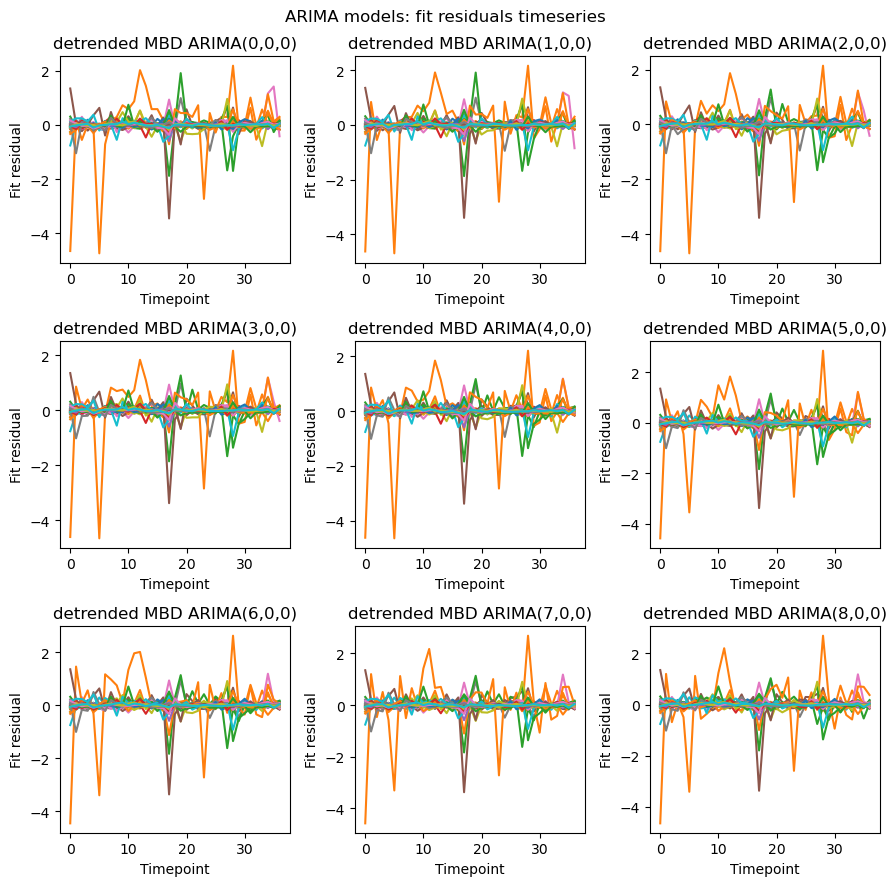

In [12]:
fig, ax = plt.subplots(len(plot_rows), len(plot_cols), figsize=(len(plot_cols) * plot_dim, len(plot_rows) * plot_dim))

for (model_string, fitted_model), subplot in zip(fitted_models.items(), product(plot_rows, plot_cols)):

    for i in range(num_counties):
        residuals = pd.DataFrame(fitted_models[model_string][i].resid)
        residuals.plot(legend=False, ax=ax[subplot])
        ax[subplot].set_xlabel(f'Timepoint')
        ax[subplot].set_ylabel(f'Fit residual')
        ax[subplot].set_title(model_string)

plt.suptitle('ARIMA models: fit residuals timeseries')
plt.tight_layout()

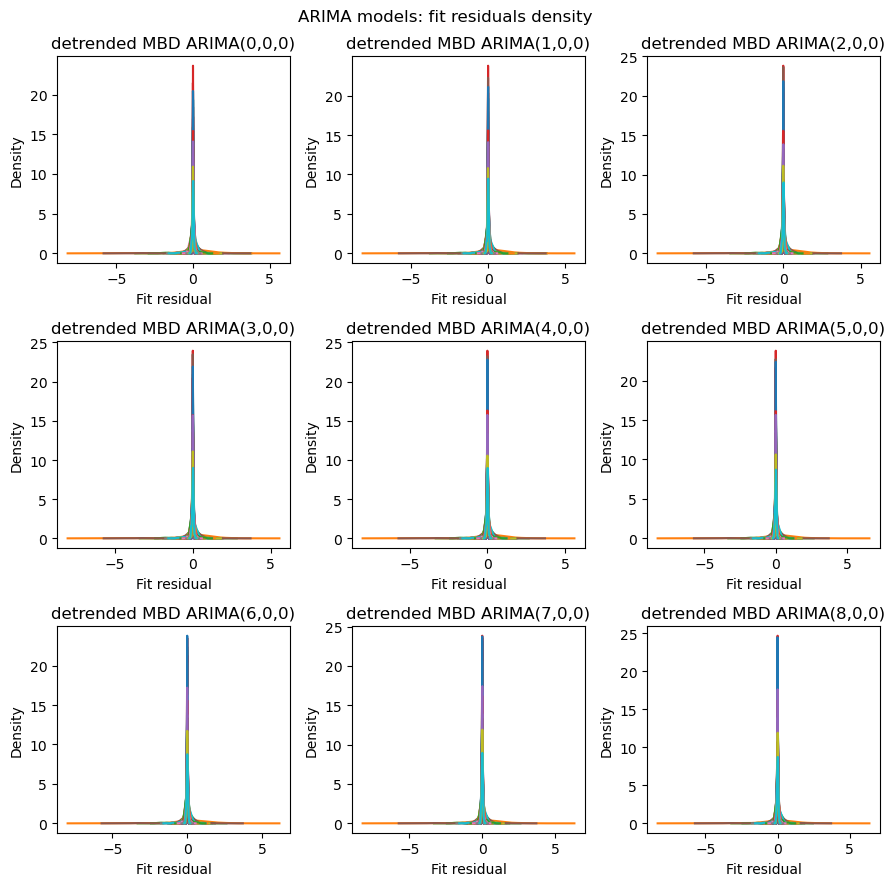

In [13]:
fig, ax = plt.subplots(len(plot_rows), len(plot_cols), figsize=(len(plot_cols) * plot_dim, len(plot_rows) * plot_dim))

for (model_string, fitted_model), subplot in zip(fitted_models.items(), product(plot_rows, plot_cols)):

    for i in range(num_counties):
        residuals = pd.DataFrame(fitted_models[model_string][i].resid)
        residuals.plot(kind='kde', legend=False, ax=ax[subplot])
        ax[subplot].set_xlabel(f'Fit residual')
        ax[subplot].set_ylabel(f'Density')
        ax[subplot].set_title(model_string)

plt.suptitle('ARIMA models: fit residuals density')
plt.tight_layout()

In [50]:
model_performance = {
    'model': [],
    'AIC': [],
    'BIC': []
}

# Loop on fitted models
for model_parameter_set, models in fitted_models.items():

    # For each model of this blocksize, collect AIC and BIC
    for model in models:
        model_performance['model'].append(model_parameter_set)
        model_performance['AIC'].append(model.aic)
        model_performance['BIC'].append(model.bic)

# Convert to pandas for easy seaborn plotting
model_performance_df = pd.DataFrame(model_performance)

# Inspect
model_performance_df.head()

,model,AIC,BIC
0,"ARIMA(0, 0, 0)",-94.068751,-90.846915
1,"ARIMA(0, 0, 0)",-25.144604,-21.922768
2,"ARIMA(0, 0, 0)",-114.844254,-111.622418
3,"ARIMA(0, 0, 0)",-170.576255,-167.354419
4,"ARIMA(0, 0, 0)",-167.838967,-164.617131


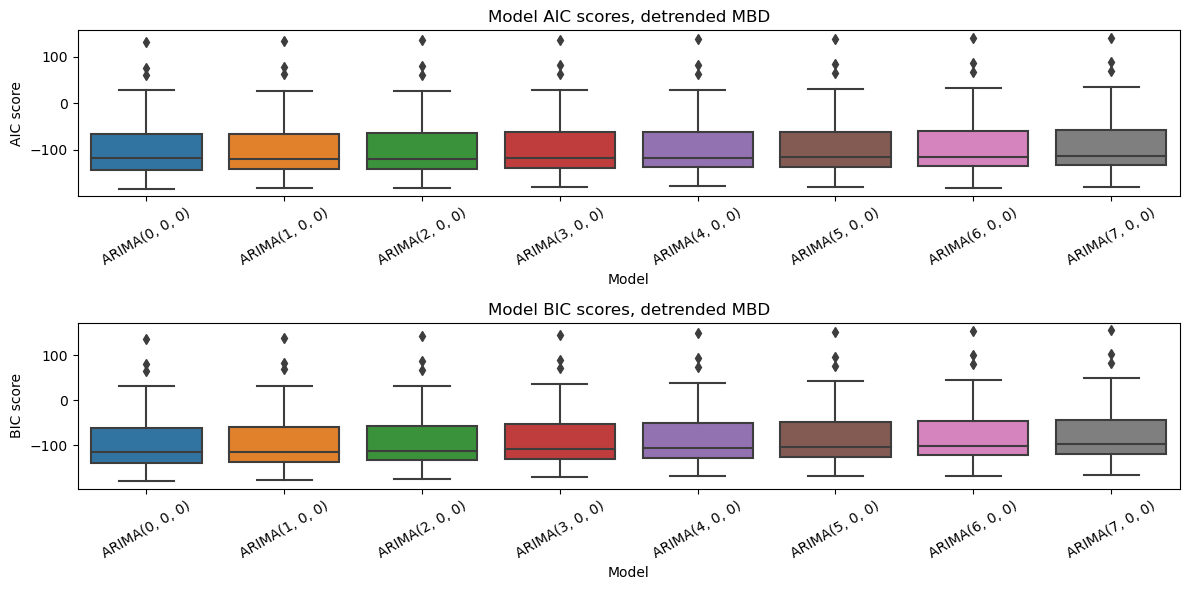

In [52]:
fig, ax = plt.subplots(2, 1,figsize=(12,6))

sns.boxplot(
    data=model_performance_df, 
    x='model',
    y='AIC',
    ax=ax[0]
)

ax[0].set(
    xlabel='Model', 
    ylabel='AIC score', 
    title='Model AIC scores, detrended MBD'
)

ax[0].tick_params(axis='x', rotation=30)

sns.boxplot(
    data=model_performance_df, 
    x='model',
    y='BIC',
    ax=ax[1]
)

ax[1].set(
    xlabel='Model', 
    ylabel='BIC score', 
    title='Model BIC scores, detrended MBD'
)

ax[1].tick_params(axis='x', rotation=30)

plt.tight_layout()
plt.show()

OK, so, what differences there are seem to be pretty subtle - this again is surprising to me. I would expect that there would be pretty significant between zero lag order and non-zero lag order.

The fit residual distributions all look pretty good to my eye, with a few exceptions. But, we already know from our preliminary bootstrapping that these models don't do anywhere near as well as the naive control, or even simple regression. I dunno, maybe we are barking up the wrong tree here.

In [34]:
fitted_models = {}
moving_average_orders = [0,1,2,3,4,5,6,7]
difference_degrees = [0]
lag_orders = [0,5]

for model_parameter_set in product(lag_orders, difference_degrees, moving_average_orders):

    print(f'Model: {model_parameter_set}')
    fitted_models[f'ARIMA{model_parameter_set}'] = []

    for i in range(num_counties):
        model = ARIMA(pd.Series(timepoints[0,i,:,5]), order=model_parameter_set)
        model_fit = model.fit()
        fitted_models[f'ARIMA{model_parameter_set}'].append(model_fit)

Model: (0, 0, 0)


/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum 

Model: (0, 0, 1)


/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Model: (0, 0, 2)


/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum 

Model: (0, 0, 3)


/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warni

Model: (0, 0, 4)


/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn(

Model: (0, 0, 5)


/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('N

Model: (0, 0, 6)


/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn(

Model: (0, 0, 7)


/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn(

Model: (5, 0, 0)


/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum 

Model: (5, 0, 1)


/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum 

Model: (5, 0, 2)


/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum 

Model: (5, 0, 3)


/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check ml

Model: (5, 0, 4)


/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as star

Model: (5, 0, 5)


/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals

Model: (5, 0, 6)


/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as star

Model: (5, 0, 7)


/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check ml

In [38]:
plot_rows = [0,1,2,3]
plot_cols = [0,1,2,3]
plot_dim = 3

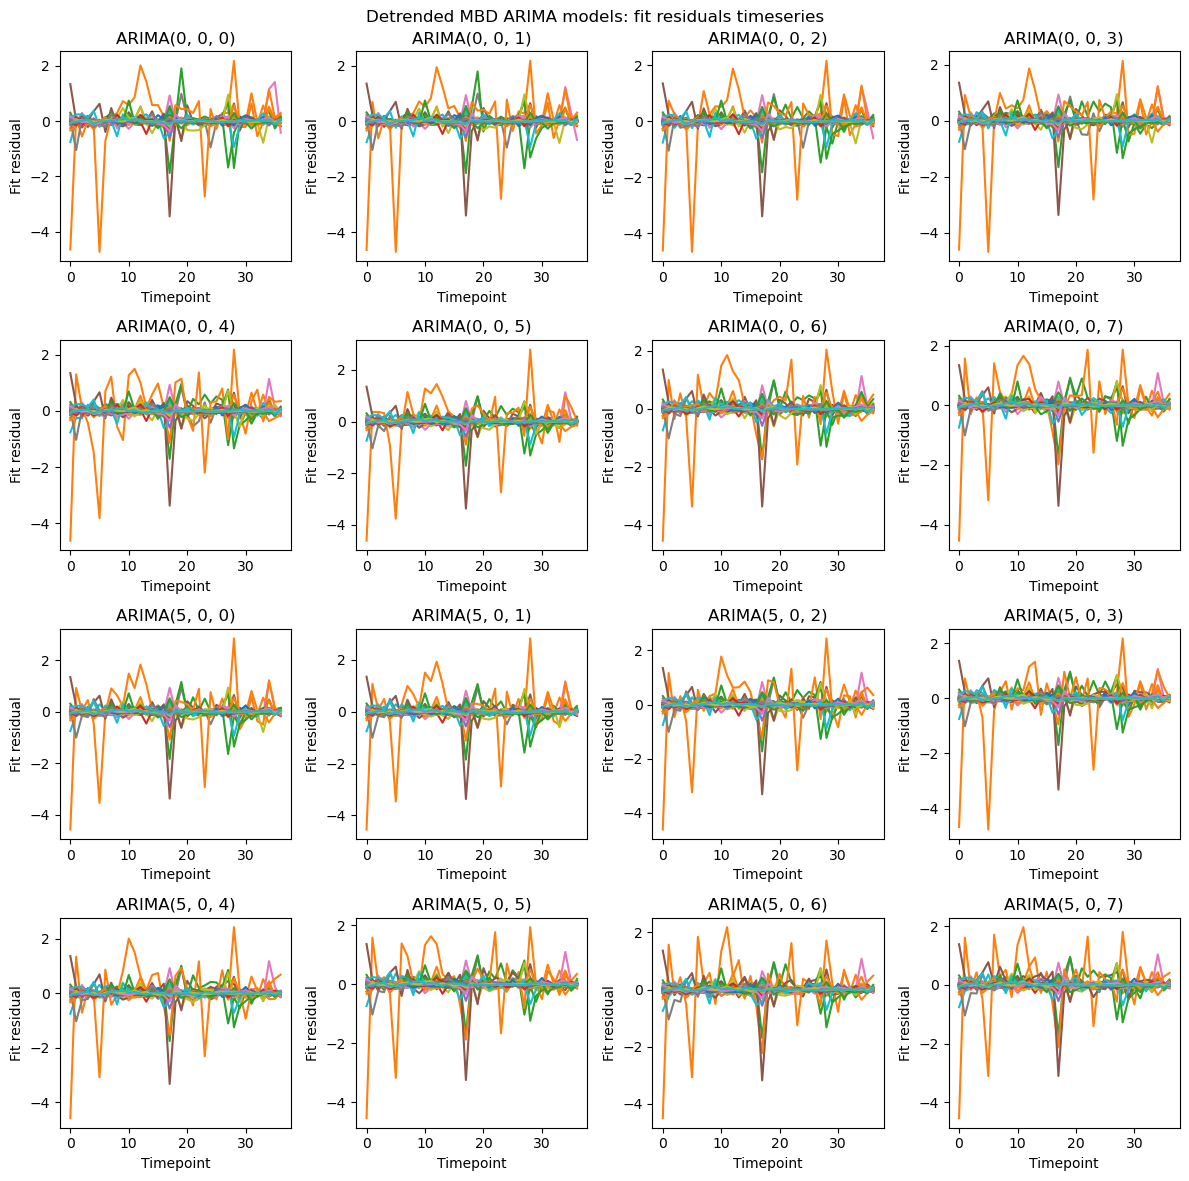

In [39]:
fig, ax = plt.subplots(len(plot_rows), len(plot_cols), figsize=(len(plot_cols) * plot_dim, len(plot_rows) * plot_dim))

for (model_string, fitted_model), subplot in zip(fitted_models.items(), product(plot_rows, plot_cols)):

    for i in range(num_counties):
        residuals = pd.DataFrame(fitted_models[model_string][i].resid)
        residuals.plot(legend=False, ax=ax[subplot])
        ax[subplot].set_xlabel(f'Timepoint')
        ax[subplot].set_ylabel(f'Fit residual')
        ax[subplot].set_title(model_string)

plt.suptitle('Detrended MBD ARIMA models: fit residuals timeseries')
plt.tight_layout()

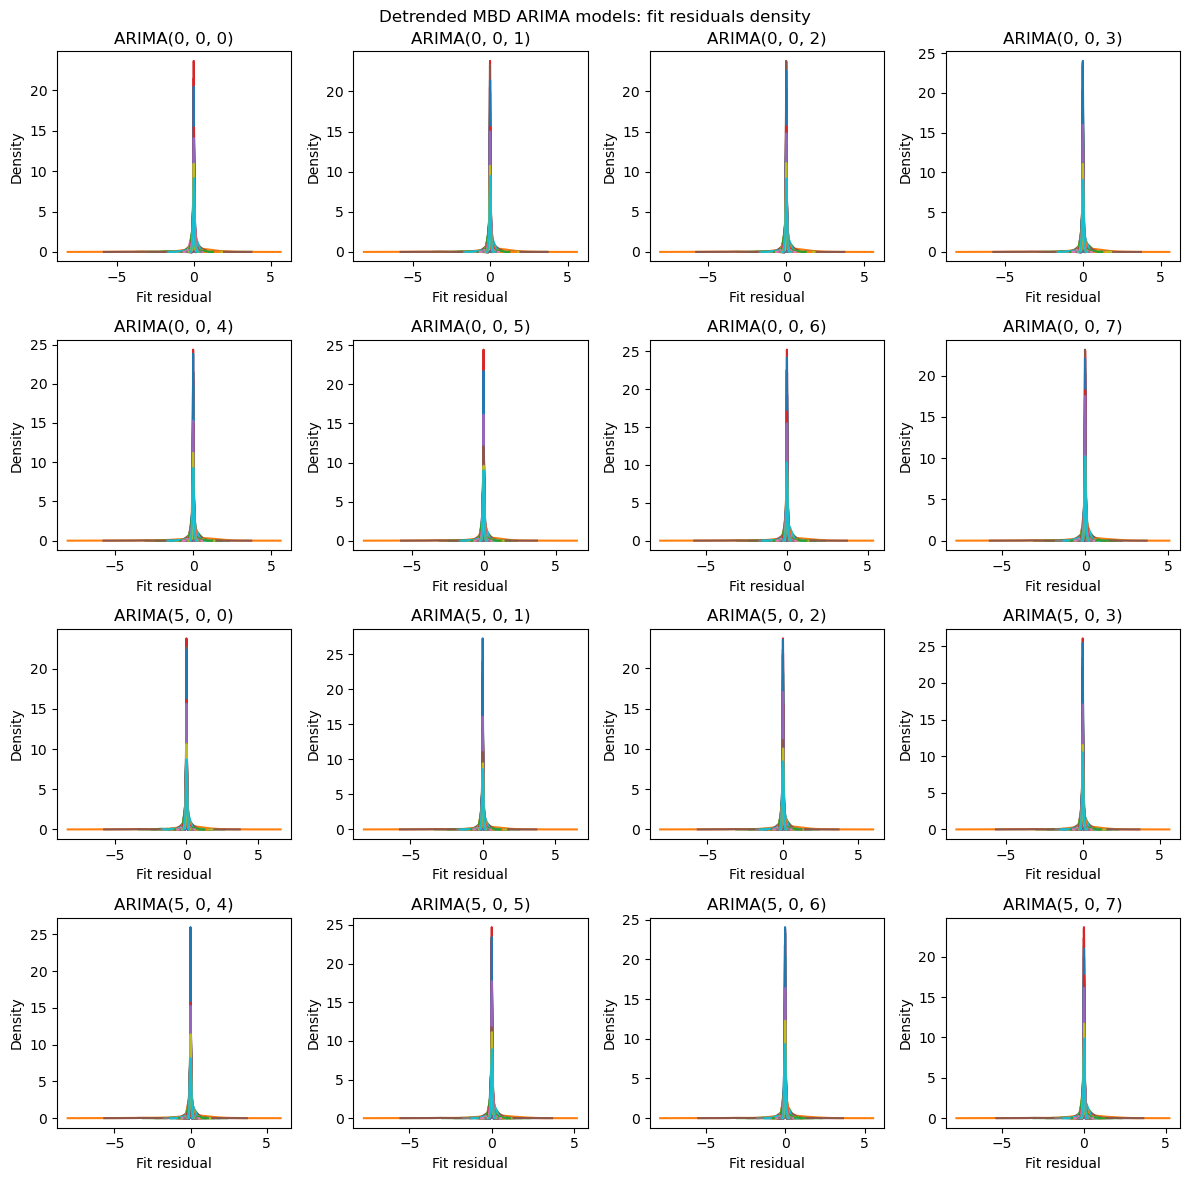

In [40]:
fig, ax = plt.subplots(len(plot_rows), len(plot_cols), figsize=(len(plot_cols) * plot_dim, len(plot_rows) * plot_dim))

for (model_string, fitted_model), subplot in zip(fitted_models.items(), product(plot_rows, plot_cols)):

    for i in range(num_counties):
        residuals = pd.DataFrame(fitted_models[model_string][i].resid)
        residuals.plot(kind='kde', legend=False, ax=ax[subplot])
        ax[subplot].set_xlabel(f'Fit residual')
        ax[subplot].set_ylabel(f'Density')
        ax[subplot].set_title(model_string)

plt.suptitle('Detrended MBD ARIMA models: fit residuals density')
plt.tight_layout()

Similar-ish results with manipulating the moving average order with a few different lag orders. Results are mostly the same visually from a manual inspection of the fit residuals. So far we have:

1. Use 1x manually detrended data with difference order set to 0.
2. Choice of lag_order doesn't appear to make a large difference in fit residuals
3. Choice of moving average order does not appear to make a large difference in fit residuals

This is a small sample and a very subjective way to consume the results, so there could be small differences that will matter with all ~3k counties that are just not obvious here. I think what we really need is a better, single number way to compare 'goodness of fit' for these models. With that, we can nail down the parameter range choices for our grid search and move on.

In [42]:
# Print some example output stats for a model from statsmodels

model_fit = fitted_models['ARIMA(0, 0, 0)'][0]

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   37
Model:                          ARIMA   Log Likelihood                  49.034
Date:                Thu, 23 Feb 2023   AIC                            -94.069
Time:                        11:58:27   BIC                            -90.847
Sample:                             0   HQIC                           -92.933
                                 - 37                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0118      0.011      1.111      0.266      -0.009       0.032
sigma2         0.0041      0.001      5.202      0.000       0.003       0.006
Ljung-Box (L1) (Q):                   0.64   Jarque-

Let's collect AIC and BIC for all of the models and use a boxplot to take a look at their distributions.

In [43]:
model_performance = {
    'model': [],
    'AIC': [],
    'BIC': []
}

# Loop on fitted models
for model_string, models in fitted_models.items():

    # For each counties model, collect model definition, AIC and BIC
    for model in models:
        model_performance['model'].append(model_string)
        model_performance['AIC'].append(model.aic)
        model_performance['BIC'].append(model.bic)

# Convert to pandas for easy seaborn plotting
model_performance_df = pd.DataFrame(model_performance)

# Inspect
model_performance_df.head()

,model,AIC,BIC
0,"ARIMA(0, 0, 0)",-94.068751,-90.846915
1,"ARIMA(0, 0, 0)",-25.144604,-21.922768
2,"ARIMA(0, 0, 0)",-114.844254,-111.622418
3,"ARIMA(0, 0, 0)",-170.576255,-167.354419
4,"ARIMA(0, 0, 0)",-167.838967,-164.617131


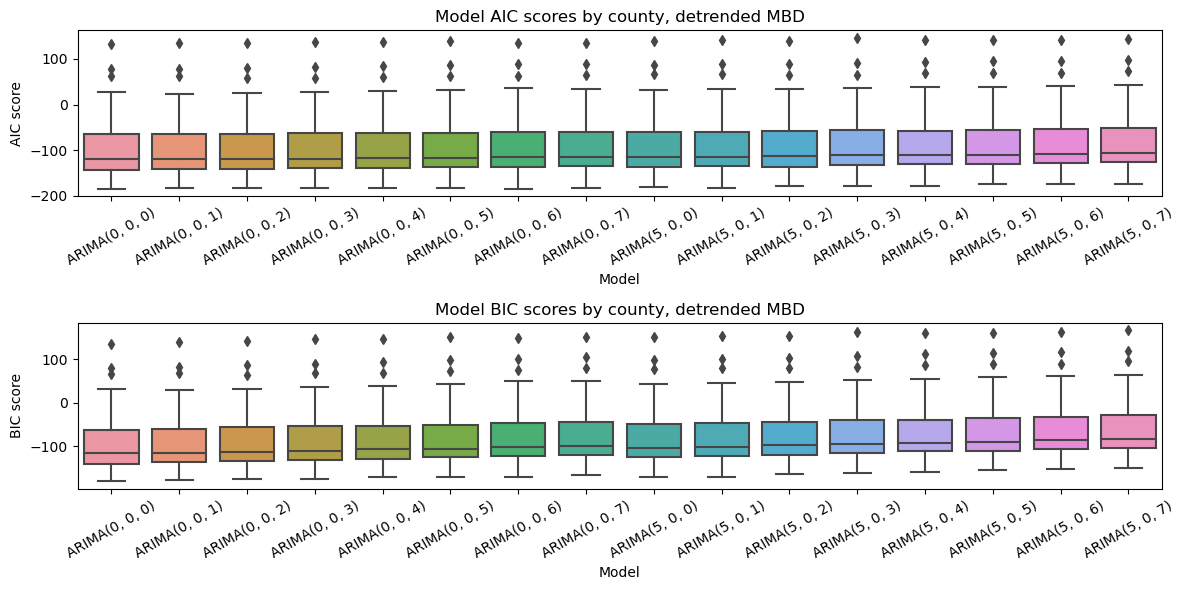

In [46]:
fig, ax = plt.subplots(2, 1,figsize=(12,6))

sns.boxplot(
    data=model_performance_df, 
    x='model',
    y='AIC',
    ax=ax[0]
)

ax[0].set(
    xlabel='Model', 
    ylabel='AIC score', 
    title='Model AIC scores by county, detrended MBD'
)

ax[0].tick_params(axis='x', rotation=30)

sns.boxplot(
    data=model_performance_df, 
    x='model',
    y='BIC',
    ax=ax[1]
)

ax[1].set(
    xlabel='Model', 
    ylabel='BIC score', 
    title='Model BIC scores by county, detrended MBD'
)

ax[1].tick_params(axis='x', rotation=30)

plt.tight_layout()
plt.show()

Ok, wild - it looks like we are not having much of an effect on 'goodness-of-fit' as determined by AIC or BIC. Models with zero lag order seem to do just slightly better, but the choice of moving average order appears to have no effect at all. What is a (0,0,0) ARIMA model anyway? Zero lags and no moving average? This is differenced data so I guess it's just an 'I' model? Kinda starting to loose hope in the approach beating the naive control. All signs point to, 'time to add exogenous data'. Before we do, I want to try two things:
1. Does the length of the input dataset matter?
2. Try bootstrapping

In regard to point 2, we are just looking at goodness of fit here, not testing out of sample predictions. Maybe these parameters will have some kind of effect on forecast accuracy? Let's try input block size, my guess is that as block size gets very small, the goodness-of-fit will improve - but obviously, this is sort of meaningless after a point.

In [21]:
fitted_models = {}

for blocksize in range(7, 38):

    print(f'block size: {blocksize}')

    input_file = f'{paths.PARSED_DATA_PATH}/{params.input_file_root_name}{blocksize}.npy'
    timepoints = np.load(input_file)

    fitted_models[blocksize] = []

    for i in range(num_counties):
        model = ARIMA(pd.Series(timepoints[0,i,:,5]), order=(0,0,0))
        model_fit = model.fit()
        fitted_models[blocksize].append(model_fit)
    


block size: 7


/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum 

block size: 8


/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum 

block size: 9


/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum 

block size: 10


/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum 

block size: 11


/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum 

block size: 12


/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum 

block size: 13


/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum 

block size: 14


/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


block size: 15


/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum 

block size: 16


/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum 

block size: 17


/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum 

block size: 18


/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum 

block size: 19


/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum 

block size: 20


/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum 

block size: 21


/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum 

block size: 22


/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum 

block size: 23


/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum 

block size: 24


/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


block size: 25


/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum 

block size: 26


/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum 

block size: 27


/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum 

block size: 28


/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum 

block size: 29


/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


block size: 30


/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum 

block size: 31


/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum 

block size: 32


/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


block size: 33


/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum 

block size: 34


/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum 

block size: 35


/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum 

block size: 36


/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum 

block size: 37


/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum 

In [22]:
model_performance = {
    'block size': [],
    'AIC': [],
    'BIC': []
}

# Loop on fitted models
for block_size, models in fitted_models.items():

    # For each model of this blocksize, collect AIC and BIC
    for model in models:
        model_performance['block size'].append(block_size)
        model_performance['AIC'].append(model.aic)
        model_performance['BIC'].append(model.bic)

# Convert to pandas for easy seaborn plotting
model_performance_df = pd.DataFrame(model_performance)

# Inspect
model_performance_df.head()

,block size,AIC,BIC
0,7,-10.429125,-10.537305
1,7,-11.757281,-11.865460
2,7,-9.564266,-9.672446
3,7,-30.749615,-30.857794
4,7,-27.440770,-27.548950


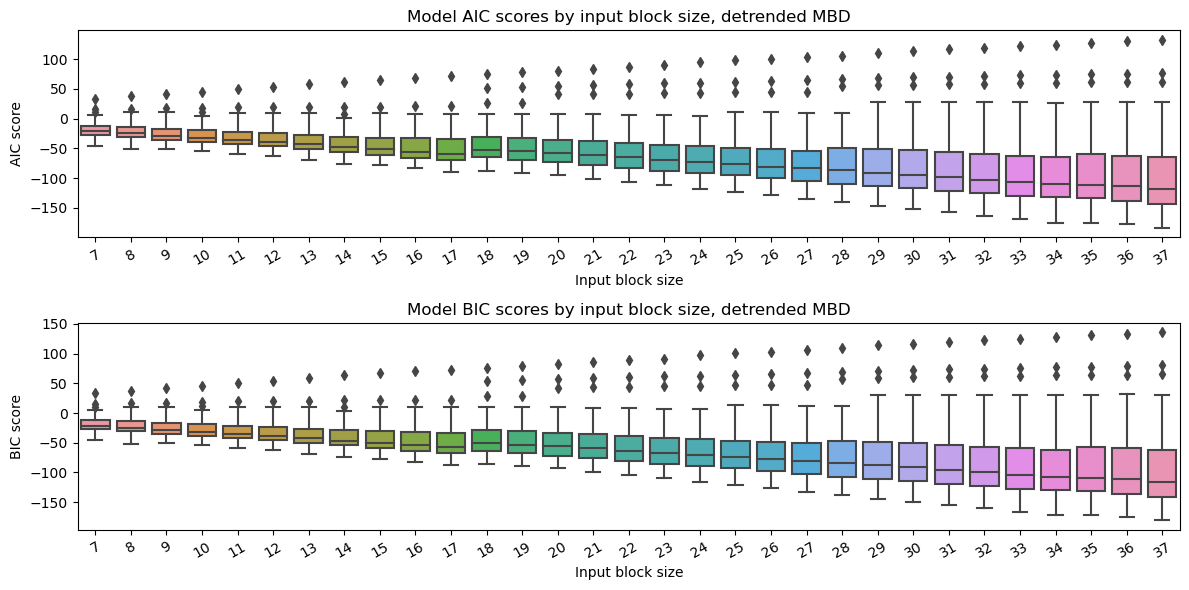

In [23]:
fig, ax = plt.subplots(2, 1,figsize=(12,6))

sns.boxplot(
    data=model_performance_df, 
    x='block size',
    y='AIC',
    ax=ax[0]
)

ax[0].set(
    xlabel='Input block size', 
    ylabel='AIC score', 
    title='Model AIC scores by input block size, detrended MBD'
)

ax[0].tick_params(axis='x', rotation=30)

sns.boxplot(
    data=model_performance_df, 
    x='block size',
    y='BIC',
    ax=ax[1]
)

ax[1].set(
    xlabel='Input block size', 
    ylabel='BIC score', 
    title='Model BIC scores by input block size, detrended MBD'
)

ax[1].tick_params(axis='x', rotation=30)

plt.tight_layout()
plt.show()